In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import root_pandas as rp
from scipy.special import factorial
from scipy.optimize import curve_fit
from lmfit import Model


Welcome to JupyROOT 6.18/04


In [2]:
data = rp.read_root("/Users/tylern/Data/ntuple/ntuple.root")

In [3]:
data = data[data.type == 0]
data.head()

,type,helicity,W,Q2,MM,MM2,Theta_E,Theta_star,Phi_star,theta,phi,sector
2,0,1,2.229266,1.326483,1.779447,3.166432,1.553717,1.156605,4.395985,21.765602,-140.907639,5
6,0,-1,2.148218,1.932373,1.708947,2.920500,1.823483,2.156084,3.739077,27.325426,74.673553,1
11,0,0,2.108829,2.638150,0.963900,0.929104,2.078120,0.854264,3.271439,35.041019,-79.896439,4
14,0,0,1.559701,1.775957,1.124512,1.264527,1.908076,0.044239,5.218319,20.042803,-141.383209,5
19,0,-1,2.037885,2.155084,1.354970,1.835943,1.903204,1.989276,3.796611,27.896715,-138.956604,5


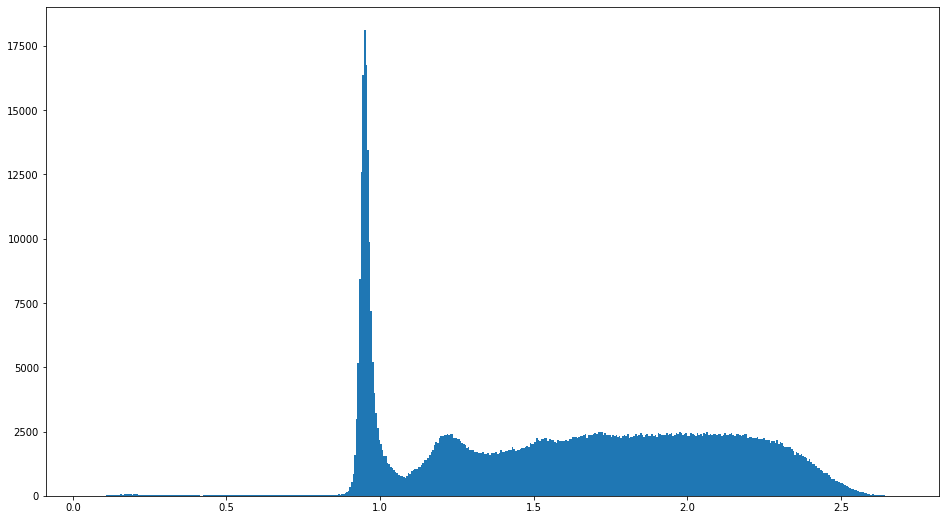

In [4]:
fig = plt.figure(figsize=(16,9))
plt.hist(data.MM, bins=500)
plt.show()

In [8]:
def gaus_fit(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def poly_fit(x, d, e, f):
    poly = d + e*x + f*x**2
    return poly
  
def bw(x, A, M, Gamma):
    g = np.sqrt((np.power(M,2)+np.power(Gamma,2)) * np.power(M,2))
    k = (2*np.sqrt(2)*M*Gamma*g)/(np.pi * np.sqrt(np.power(M,2) + g) )
    f = A*k/(np.power((np.power(x,2) - np.power(M,2)),2 + np.power(M,2)*np.power(Gamma,2)))
    f = np.nan_to_num(f)
    return f
    
def gaus_poly(x, A, mu, sig, d, e, f):
    gaus = gaus_fit(x, A, mu, sig)
    poly = poly_fit(x, d, e, f)
    return gaus + poly

def double_gaus(x, A, mu, sig, A_bck, mu_bck, sig_bck):
    gaus = gaus_fit(x, A, mu, sig)
    gaus_bck = gaus_fit(x, A_bck, mu_bck, sig_bck)
    return gaus + gaus_bck

def plot_mm_N(data, bins=200, range=(0.88, 1.15)):
    fig = plt.figure(figsize=(16,9))    
    ys,xs = np.histogram(data, range=range, bins=bins, density=True)
    xs = (xs[:-1]+xs[1:])/2.0
 
    mod = Model(double_gaus)
    pars = mod.make_params(A=np.max(ys), mu=0.93, sig=1.5E-2, A_bck=2.0, mu_bck=1.0, sig_bck=1.5E-1)
    mod.set_param_hint("mu", value=0.93, vary=1E-4, min=0.9, max=0.05)
    result = mod.fit(ys, pars,method='emcee', x=xs)
    plt.plot(xs, result.best_fit, 'r-', 
             label=f"gaus poly lmfit:\t$\mu = $ {result.best_values['mu']:0.4f}   $\sigma =$ {result.best_values['sig']:0.4f}")

    
        
    g_params, g_covariance = curve_fit(gaus_fit, xs, ys, 
                                       p0=[np.max(ys), 0.93, 1.5E-2], maxfev = 8000)

    x = np.linspace(np.min(xs), np.max(xs),200)
    gp_params, gp_covariance = curve_fit(gaus_poly, xs, ys, 
                                         p0=[*g_params, 1.0, 1.0,1.0], maxfev = 8000)
    
    
    plt.errorbar(xs, ys, yerr=np.std(ys)/100, fmt='.')
    plt.plot(x, gaus_fit(x,*g_params), 
             label=f"gaus curve_fit:\t\t$\mu = $ {g_params[1]:0.4f}   $\sigma =$ {g_params[2]:0.4f}")
    #plt.plot(x, gaus_fit(x,*gp_params[0:3]))
    #plt.plot(x, poly_fit(x,*gp_params[3:]))
    plt.plot(x, gaus_poly(x,*gp_params),
            label=f"gaus poly curve_fit:\t$\mu = $ {gp_params[1]:0.4f}   $\sigma =$ {gp_params[2]:0.4f}")
    plt.legend(loc='best')
    
    _min = gp_params[1]-3*gp_params[2]
    _max = gp_params[1]+3*gp_params[2]
    plt.axvline(_min, 0, 10)
    plt.axvline(_max, 0, 10)

    
    plt.show()
             
    return _min, _max

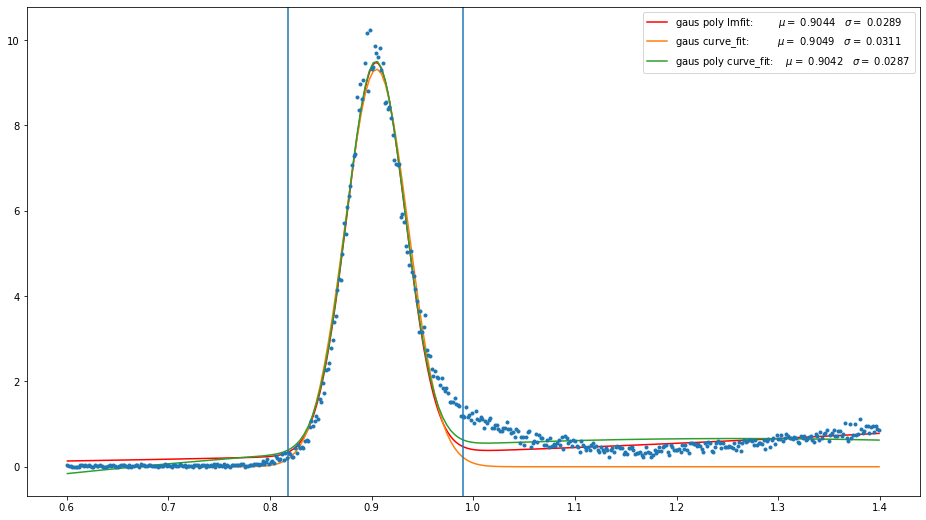

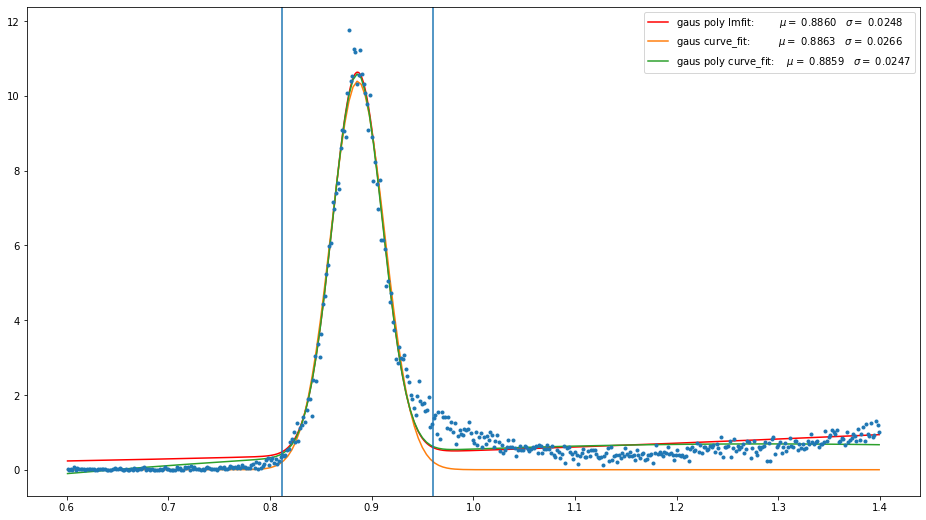

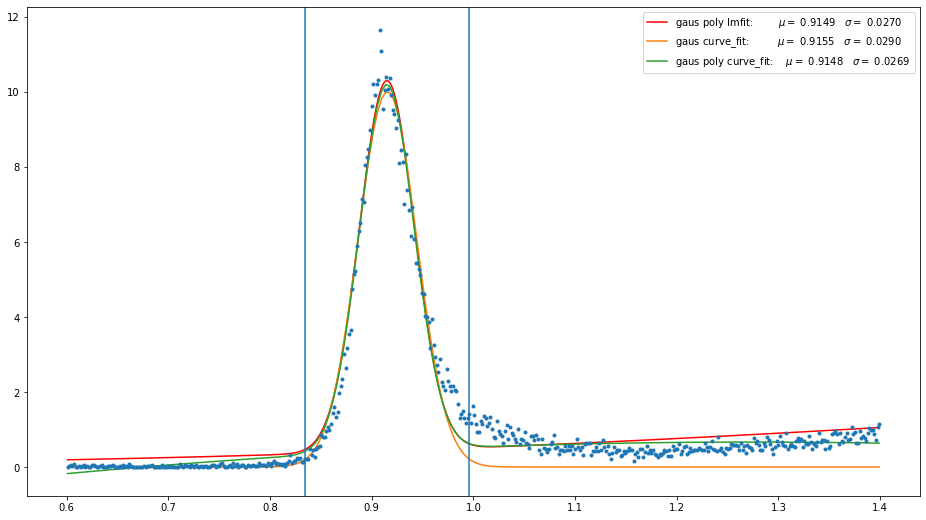

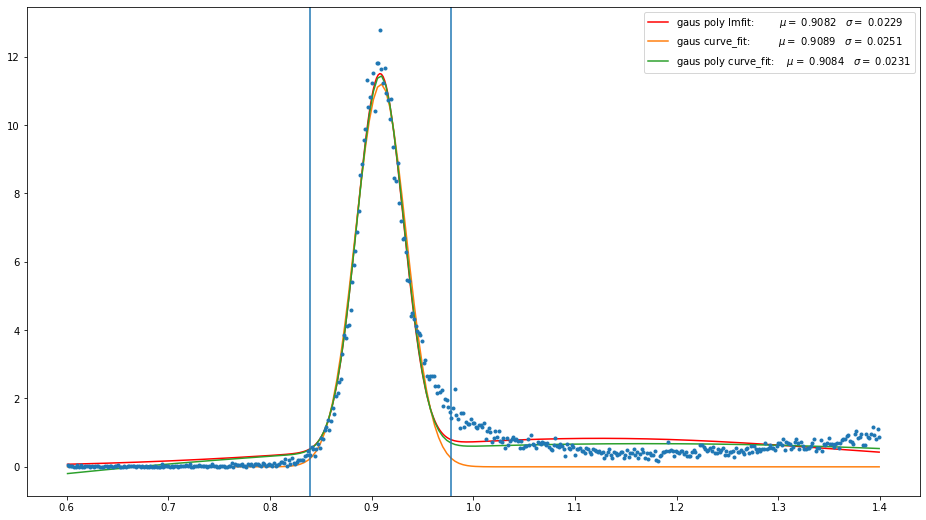

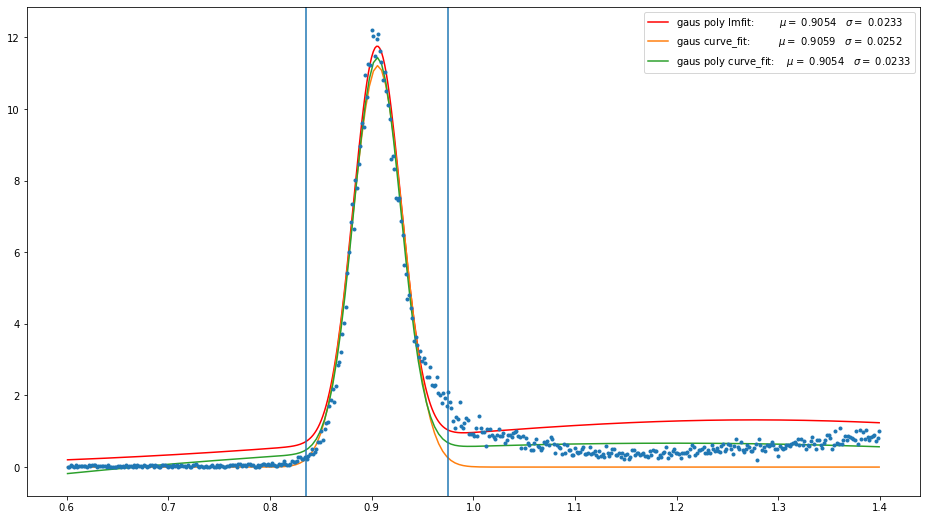

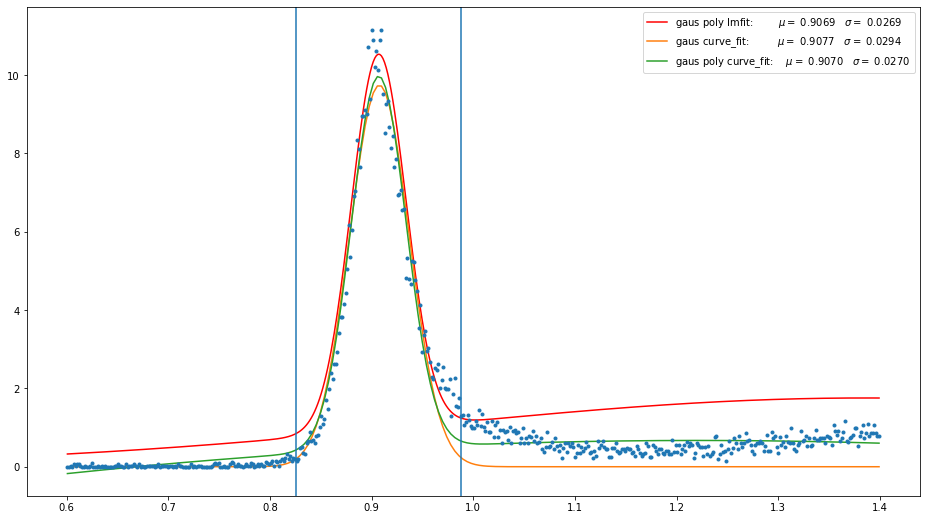

[[1, 0.8180330986973933, 0.9903628878397613], [2, 0.8116376606082534, 0.9601161400657645], [3, 0.8341990611614862, 0.9954785783072186], [4, 0.839022537122203, 0.9778703017300004], [5, 0.8353617887442198, 0.9754468092494691], [6, 0.826091759804154, 0.9878136063665097]]


In [9]:
mm_sec_cut = []
for sec in range(1,7):
    cuts = plot_mm_N(data[data.sector == sec].MM2, bins=500, range=(0.6,1.4))
    mm_sec_cut.append([sec, cuts[0], cuts[1]])
    
print(mm_sec_cut)